In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [3]:
IT_finance = pd.read_excel('./data/dongboo/IT_TOTAL_재무사항.xlsx')


In [4]:
# krx에서 가져온 자료
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')


# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [5]:
IT = pd.merge(IT_finance,IT_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])


In [6]:
# del IT['주식매입선택권.1']

# 회사별로 분리

In [7]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

In [8]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [9]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재),* (정상)영업손익(계산수치),기타이익(*),이자수익,배당금수익,외환거래이익(*),외환차익,외환환산이익,기타외화거래이익,보험차익.1,퇴직연금운용이익,전기오류수정이익,기타.2,기타손실(*),이자비용,외환거래손실(*),외환차손,외화환산손실,기타외환거래손실,법인세추납액,퇴직연금운용손실,전기오류수정손실,기타.3,법인세비용차감전순이익(손실),법인세비용,종속회사 매수일전 순손익,처분된 종속회사 순손익,계속영업이익(손실),중단영업이익(손실),*중단영업손익 법인세효과,당기순이익(손실),기타포괄손익(*),금융자산평가손익.1,매도가능금융자산평가손익.1,관계기업 등 기타포괄손익.1,환산 관련 외환차이(환율변동차이),해외사업장순투자위험회피,현금흐름위험회피 적립금.1,확정급여제도의 보험수리적손익,주식기준보상 적립금.1,재평가손익.1,기타.4,기타포괄손익관련 법인세,총포괄손익,*(당기순손익 귀속)지배기업주주지분,*계속영업손익,*중단영업손익,*(당기순손익 귀속)비지배주주지분,*계속영업손익.1,*중단영업손익.1,*(총포괄손익 귀속)지배기업주주지분,*(총포괄손익 귀속)비지배주주지분,*주당계속영업이익,*주당순손익,*희석주당계속영업이익,*희석주당순손익,*(지배기업주주지분)주당계속영업이익,*(지배기업주주지분)주당순손익,*(지배기업주주지분)희석주당계속영업이익,*(지배기업주주지분)희석주당순손익,* 성격별 비용계정(*),제품과 재공품의 변동,기업이 수행한 용역으로서 자본화되어 있는 부분,원재료와 저장품(소모품)의 사용액,상품의 판매,기타원가,종업원 급여비용,감가상각비와 기타상각비 및 손상차손,세금과공과,대손상각비,물류비(운송보관),광고 및 판매촉진비,임차료 및 리스료,경상연구개발비,기타비용,기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.5,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.6,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.2,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.7,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.8,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.2,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.2,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.9,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.10,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.2,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.11,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.12,(종속회사의 배당금),기타.13,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.3,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,현금흐름위험회피 적립금.3,주식기준보상 적립금.3,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.14,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.15,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.16,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분할(양수도등)으로 인한 현금유출액,기타투자활동으로 인한 현금유출액,이자수입.1,이자지급(-).1,배당금수입.1,배당금지급(-).1,법인세환입.1,법인세납부(-).1,중단영업관련 현금흐름.1,재무활동으로 인한 현금흐름(*),재무활동으로 인한 현금유입액(*),기타부채의 증가,유상증자,자본금의 증가,자본잉여금의 증가,종속회사의 증자 등,이익잉여금의 증가,자기주식의 처분,주식매입선택권의 행사,연결자본거래로인한현금유입액,종속기업 소유지분 변동에 따른 현금흐름,비지배주주지분의 증가,정부보조금 등의 변동.3,환율변동으로인한 차이조정,합병분할(양수도등)으로 인한 현금유입액.1,기타재무활동으로 인한 현금유입액,(재무활동으로 인한 현금유출액)(*),유상감자,자본금의 감소,자본잉여금의 감소,종속회사의 감자 등,이익잉여금의 감소,자기주식의 취득,연결자본거래로인한현금유출액,종속기업 소유지분 변동

In [10]:
# 3개월 후 오르는 지 안오르는 지 확인하는 모델이기에
# 마지막 행은 올랐는지 확인할 수가 없음
# 이에 마지막 행 제외시킴

lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]


In [11]:
hynix

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재),* (정상)영업손익(계산수치),기타이익(*),이자수익,배당금수익,외환거래이익(*),외환차익,외환환산이익,기타외화거래이익,보험차익.1,퇴직연금운용이익,전기오류수정이익,기타.2,기타손실(*),이자비용,외환거래손실(*),외환차손,외화환산손실,기타외환거래손실,법인세추납액,퇴직연금운용손실,전기오류수정손실,기타.3,법인세비용차감전순이익(손실),법인세비용,종속회사 매수일전 순손익,처분된 종속회사 순손익,계속영업이익(손실),중단영업이익(손실),*중단영업손익 법인세효과,당기순이익(손실),기타포괄손익(*),금융자산평가손익.1,매도가능금융자산평가손익.1,관계기업 등 기타포괄손익.1,환산 관련 외환차이(환율변동차이),해외사업장순투자위험회피,현금흐름위험회피 적립금.1,확정급여제도의 보험수리적손익,주식기준보상 적립금.1,재평가손익.1,기타.4,기타포괄손익관련 법인세,총포괄손익,*(당기순손익 귀속)지배기업주주지분,*계속영업손익,*중단영업손익,*(당기순손익 귀속)비지배주주지분,*계속영업손익.1,*중단영업손익.1,*(총포괄손익 귀속)지배기업주주지분,*(총포괄손익 귀속)비지배주주지분,*주당계속영업이익,*주당순손익,*희석주당계속영업이익,*희석주당순손익,*(지배기업주주지분)주당계속영업이익,*(지배기업주주지분)주당순손익,*(지배기업주주지분)희석주당계속영업이익,*(지배기업주주지분)희석주당순손익,* 성격별 비용계정(*),제품과 재공품의 변동,기업이 수행한 용역으로서 자본화되어 있는 부분,원재료와 저장품(소모품)의 사용액,상품의 판매,기타원가,종업원 급여비용,감가상각비와 기타상각비 및 손상차손,세금과공과,대손상각비,물류비(운송보관),광고 및 판매촉진비,임차료 및 리스료,경상연구개발비,기타비용,기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.5,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.6,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.2,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.7,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.8,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.2,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.2,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.9,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.10,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.2,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.11,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.12,(종속회사의 배당금),기타.13,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.3,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,현금흐름위험회피 적립금.3,주식기준보상 적립금.3,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.14,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.15,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.16,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분할(양수도등)으로 인한 현금유출액,기타투자활동으로 인한 현금유출액,이자수입.1,이자지급(-).1,배당금수입.1,배당금지급(-).1,법인세환입.1,법인세납부(-).1,중단영업관련 현금흐름.1,재무활동으로 인한 현금흐름(*),재무활동으로 인한 현금유입액(*),기타부채의 증가,유상증자,자본금의 증가,자본잉여금의 증가,종속회사의 증자 등,이익잉여금의 증가,자기주식의 처분,주식매입선택권의 행사,연결자본거래로인한현금유입액,종속기업 소유지분 변동에 따른 현금흐름,비지배주주지분의 증가,정부보조금 등의 변동.3,환율변동으로인한 차이조정,합병분할(양수도등)으로 인한 현금유입액.1,기타재무활동으로 인한 현금유입액,(재무활동으로 인한 현금유출액)(*),유상감자,자본금의 감소,자본잉여금의 감소,종속회사의 감자 등,이익잉여금의 감소,자기주식의 취득,연결자본거래로인한현금유출액,종속기업 소유지분 변동

# 산업별 변수 <3개월 후 종가>와의 상관관계 분석

In [12]:
# 밑에 함수로 해보기!!!!

In [13]:
lg_corr = lg.corr(method = 'pearson')
df_lg = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg.columns = ['지표','3개월후종가']

sdi_corr = sdi.corr(method = 'pearson')
df_sdi = pd.DataFrame(sdi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi.columns = ['지표','3개월후종가']

ssem_corr = ssem.corr(method = 'pearson')
df_ssem = pd.DataFrame(ssem_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem.columns = ['지표','3개월후종가']

hynix_corr = hynix.corr(method = 'pearson')
df_hynix = pd.DataFrame(hynix_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix.columns = ['지표','3개월후종가']

# 산업별 상관관계 데이터프레임

In [14]:
pd.concat([df_lg.reset_index(drop = True), df_sdi.reset_index(drop = True), df_ssem.reset_index(drop = True), df_hynix.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.767493,최고가,0.820795,최고가,0.827799,종가,0.948256
2,종가,0.747660,종가,0.809146,종가,0.818502,최고가,0.947936
3,최저가,0.712841,최저가,0.781223,최저가,0.801165,최저가,0.944148
4,거래대금,0.686572,회계정책변경누적효과.4,0.593481,거래대금,0.730220,* (정상)영업손익(계산수치),0.930893
5,거래량,0.598758,정부보조금 등의 변동.1,0.580991,해외사업장순투자위험회피 적립금,0.703484,* (정상)영업손익(보고서기재),0.928501
6,기말이익잉여금(결손금)(*),0.539389,미처분이익잉여금(결손금),0.474870,* (정상)영업손익(보고서기재),0.659242,법인세비용차감전순이익(손실),0.918030
7,이익잉여금(결손금)(*),0.539389,매도가능금융자산 평가손익.1,0.461993,* (정상)영업손익(계산수치),0.655114,*(지배기업주주지분)주당순손익,0.915234
8,*(당기순손익 귀속)지배기업주주지분,0.517290,이자지급(-),0.453903,거래량,0.593055,*(지배기업주주지분)주당계속영업이익,0.915234
9,당기순이익(손실),0.517248,* (정상)영업손익(계산수치),0.441103,기초자본잉여금,0.545441,*(당기순손익 귀속)지배기업주주지분,0.914956


In [15]:
list_corr = []
order = 30 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg.index[:order])):
    list_corr.append(df_lg.index[:order][i])
    list_corr.append(df_sdi.index[:order][i])
    list_corr.append(df_ssem.index[:order][i])
    list_corr.append(df_hynix.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [16]:
var = []
for i in range(len(variable)):
    var.append(df_lg[df_lg.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [17]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]
corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr

,var_index,var,number
0,108,총포괄손익,4
1,366,최고가,4
2,367,최저가,4
3,59,미처분이익잉여금(결손금),4
4,368,종가,4
5,66,* (정상)영업손익(계산수치),4
6,95,당기순이익(손실),3
7,88,법인세비용차감전순이익(손실),3
8,89,법인세비용,3
9,370,거래대금,3


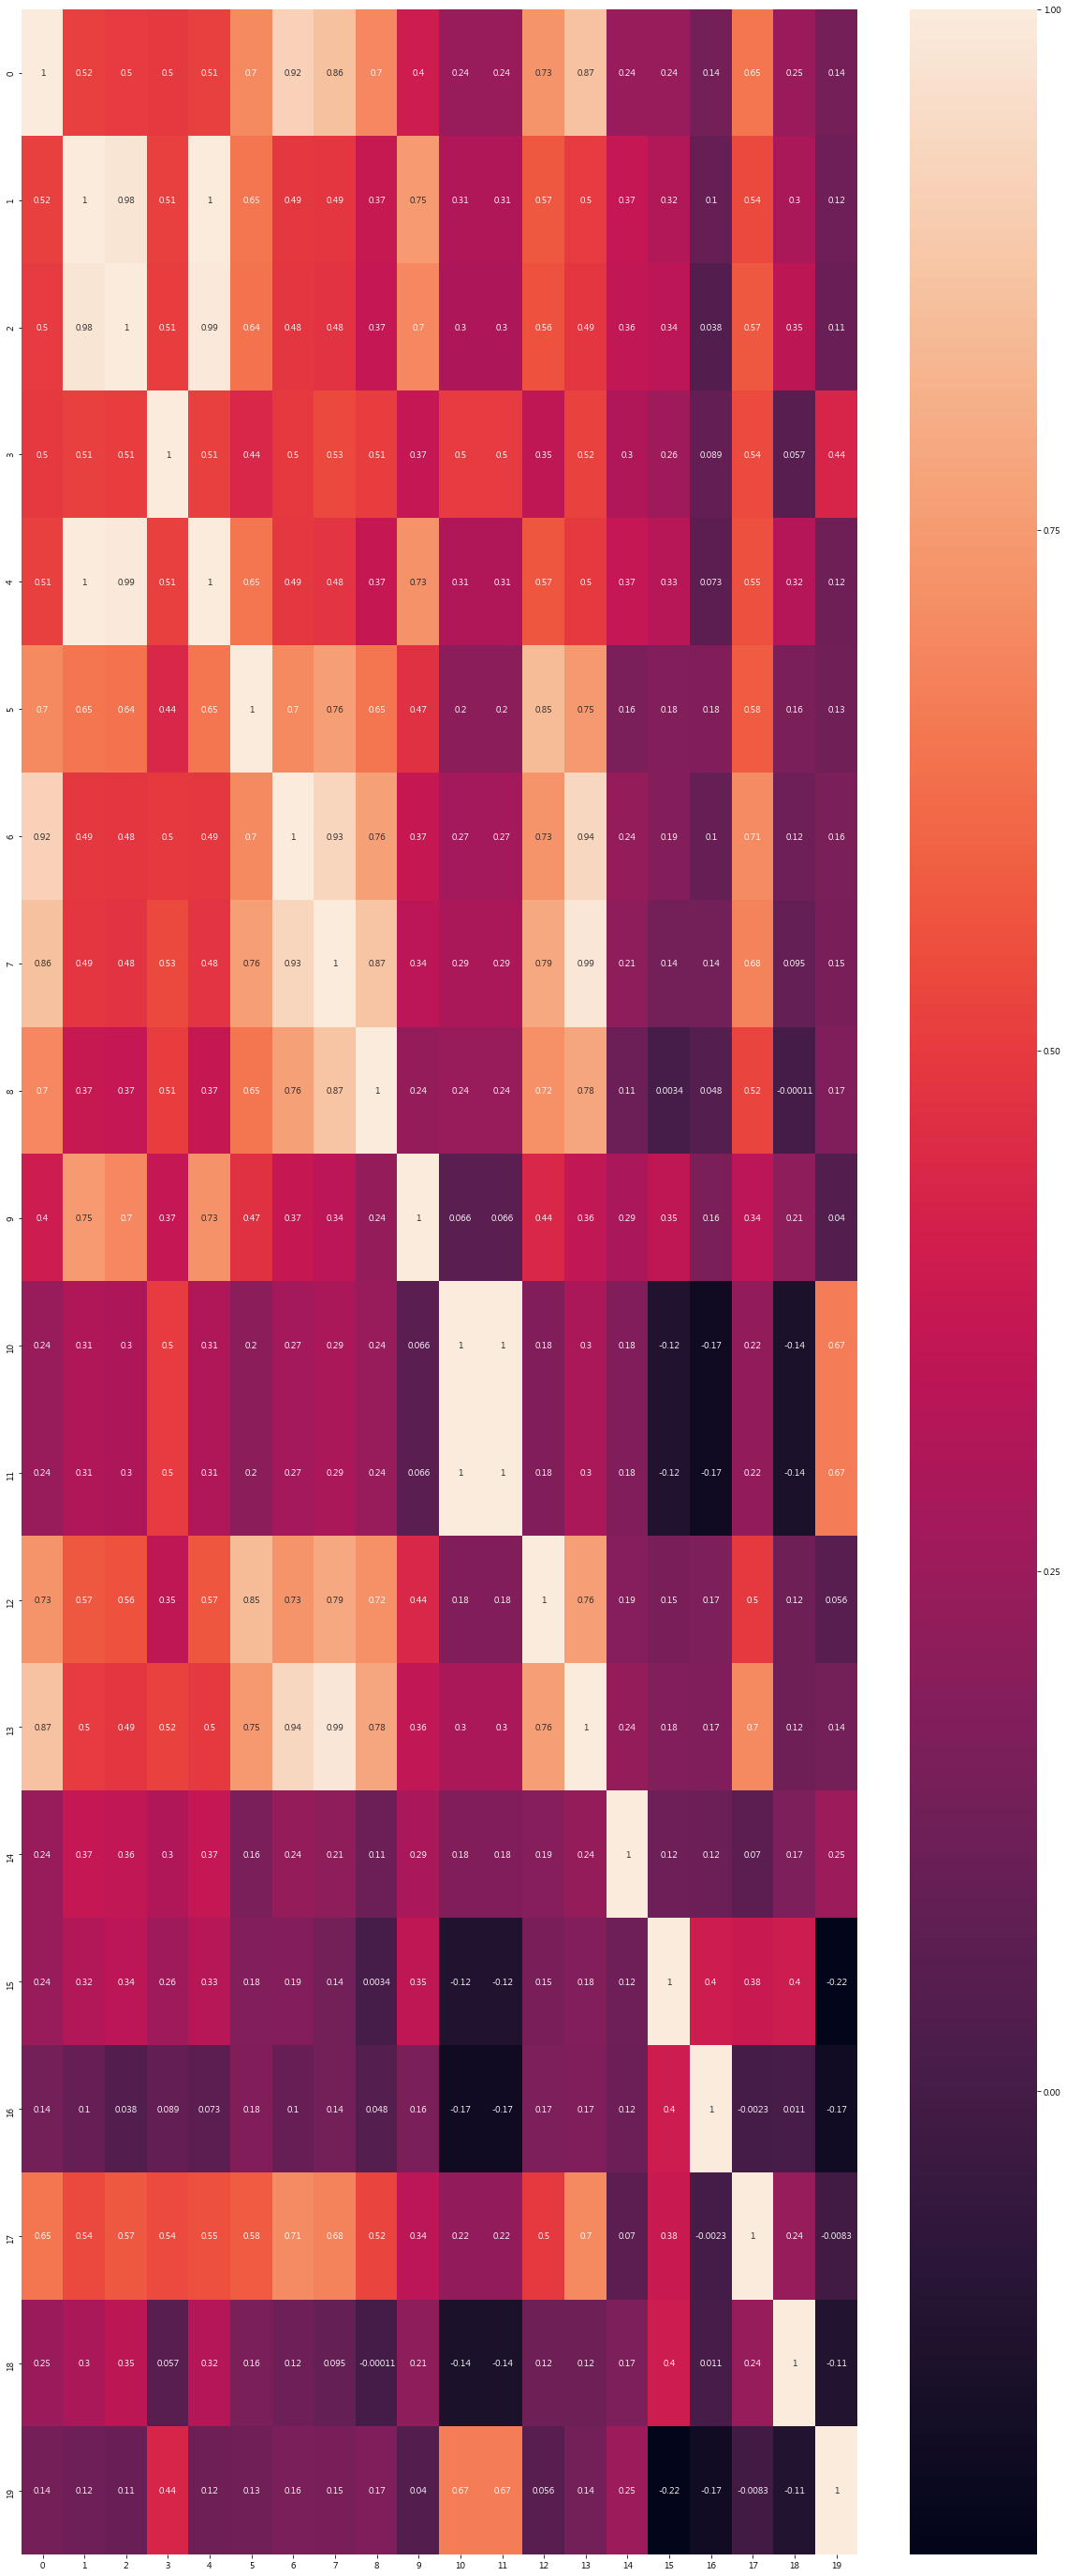

In [46]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_IT.corr(), annot = True)
# plt.savefig('tmp.png')

In [45]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

# 위 자료를 보고 변수 선정

In [18]:
deep_lg = lg[corr['var'][0:20]]
deep_sdi = sdi[corr['var'][0:20]]
deep_ssem = ssem[corr['var'][0:20]]
deep_hynix = hynix[corr['var'][0:20]]

deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

In [19]:
deep_lg

,총포괄손익,최고가,최저가,미처분이익잉여금(결손금),종가,* (정상)영업손익(계산수치),당기순이익(손실),법인세비용차감전순이익(손실),법인세비용,거래대금,기말이익잉여금(결손금)(*),이익잉여금(결손금)(*),* (정상)영업손익(보고서기재),계속영업이익(손실),이자지급(-),* (비지배)당기순손익,*(총포괄손익 귀속)비지배주주지분,* (지배)당기순손익,매도가능금융자산 평가손익,이익준비금,수익률상승하락
0,42143168,128500,97800,265369000,113150,41554974,47401856,41080355,-420898,644359793314,395502495,395502495,42395332,41501253,-13129954,-21424,218586,47423280,37,16576000,1.0
1,112908596,173000,156500,366534000,164750,79851762,101442004,62848450,25237481,1009752795890,496667080,496667080,86912500,37610969,-22735483,200701,-323131,148643159,209000,16576000,0.0
2,54713459,147000,132500,427961000,139750,68547655,66638920,59874975,-6932793,1165922704000,558093916,558093916,63152758,66807768,-36659938,241050,179216,215241730,208440,16576000,0.0
3,-23375019,135500,127500,0,131500,-36793272,-19651440,-55127153,-35173671,549851086500,533032081,533032081,-36004758,-19953483,-52640320,239930,-1120,195591409,208093,16576000,0.0
4,-14479538,126500,112000,385654768,119250,-8786085,-9530267,-26674417,-17144150,597488403500,516492768,516492768,-7369064,-9530267,-18097065,-1267,-1267,-9529000,-73,17280000,0.0
5,-9702461,99900,93200,378690000,96550,9623556,-6975403,-15194170,-8218767,199759286700,509528114,509528114,5914429,-6975403,-39608423,-2205,-938,-16503464,0,17280000,0.0
6,-13257642,70700,56200,343096000,63450,-15828492,-35552775,-43309363,-7756588,208123631400,473934034,473934034,-5366696,-35552775,-62505441,-3291,-1086,-52055153,-285683,17280000,1.0
7,-103594761,73100,67500,241422000,70300,-27898047,-93316075,-89294631,4021443,193145613600,372260465,372260465,-60014817,-93316075,-87254065,-17274,-13983,-145357246,-1092,17280000,1.0
8,-5343820,107000,94000,239037376,100500,18258822,-2432253,43058,2475311,478587655600,369875376,369875376,23863085,-2432253,-24554554,-418,-418,-2431835,661,17280000,0.0
9,6102098,91400,73300,243492000,82350,15243876,4459276,-7965601,-12424877,183233907400,374329613,374329613,19046931,4459276,-49416604,-500,-82,2027523,661,17280000,1.0


In [20]:
deep_lg

,총포괄손익,최고가,최저가,미처분이익잉여금(결손금),종가,* (정상)영업손익(계산수치),당기순이익(손실),법인세비용차감전순이익(손실),법인세비용,거래대금,기말이익잉여금(결손금)(*),이익잉여금(결손금)(*),* (정상)영업손익(보고서기재),계속영업이익(손실),이자지급(-),* (비지배)당기순손익,*(총포괄손익 귀속)비지배주주지분,* (지배)당기순손익,매도가능금융자산 평가손익,이익준비금,수익률상승하락
0,42143168,128500,97800,265369000,113150,41554974,47401856,41080355,-420898,644359793314,395502495,395502495,42395332,41501253,-13129954,-21424,218586,47423280,37,16576000,1.0
1,112908596,173000,156500,366534000,164750,79851762,101442004,62848450,25237481,1009752795890,496667080,496667080,86912500,37610969,-22735483,200701,-323131,148643159,209000,16576000,0.0
2,54713459,147000,132500,427961000,139750,68547655,66638920,59874975,-6932793,1165922704000,558093916,558093916,63152758,66807768,-36659938,241050,179216,215241730,208440,16576000,0.0
3,-23375019,135500,127500,0,131500,-36793272,-19651440,-55127153,-35173671,549851086500,533032081,533032081,-36004758,-19953483,-52640320,239930,-1120,195591409,208093,16576000,0.0
4,-14479538,126500,112000,385654768,119250,-8786085,-9530267,-26674417,-17144150,597488403500,516492768,516492768,-7369064,-9530267,-18097065,-1267,-1267,-9529000,-73,17280000,0.0
5,-9702461,99900,93200,378690000,96550,9623556,-6975403,-15194170,-8218767,199759286700,509528114,509528114,5914429,-6975403,-39608423,-2205,-938,-16503464,0,17280000,0.0
6,-13257642,70700,56200,343096000,63450,-15828492,-35552775,-43309363,-7756588,208123631400,473934034,473934034,-5366696,-35552775,-62505441,-3291,-1086,-52055153,-285683,17280000,1.0
7,-103594761,73100,67500,241422000,70300,-27898047,-93316075,-89294631,4021443,193145613600,372260465,372260465,-60014817,-93316075,-87254065,-17274,-13983,-145357246,-1092,17280000,1.0
8,-5343820,107000,94000,239037376,100500,18258822,-2432253,43058,2475311,478587655600,369875376,369875376,23863085,-2432253,-24554554,-418,-418,-2431835,661,17280000,0.0
9,6102098,91400,73300,243492000,82350,15243876,4459276,-7965601,-12424877,183233907400,374329613,374329613,19046931,4459276,-49416604,-500,-82,2027523,661,17280000,1.0


In [21]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [22]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

In [23]:
# 이게 맞나?? 이렇게 상관관계 볼 수 있나??
# scale_IT.corr()

# 상관관계 표 보기

In [24]:
# import matplotlib.pyplot as plt
# from matplotlib import font_manager, rc
# import seaborn as sns
# import matplotlib
# font_location = "c:/Windows/fonts/malgun.ttf"
# font_name = font_manager.FontProperties(fname=font_location).get_name()
# matplotlib.rc('font', family=font_name)

In [25]:
# plt.figure(figsize=(20,50))

# sns.heatmap(data = deep_IT.corr(), annot = True)
# # plt.savefig('tmp.png')

In [26]:
def xavier_init(n_inputs, n_outputs, uniform=True):
    if uniform:
        # 6 was used in the paper.
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limints as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [27]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_IT
y_data = deep_IT.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4, W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [28]:
# Launch graph

validation_number = 20


with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(9001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 0.8961325883865356
Step : 1 	 Cost : 1.011926531791687
Step : 2 	 Cost : 0.9332036375999451
Step : 3 	 Cost : 1.0772888660430908
Step : 4 	 Cost : 1.0438050031661987
Step : 5 	 Cost : 1.0484960079193115
Step : 6 	 Cost : 0.8845113515853882
Step : 7 	 Cost : 0.9958098530769348
Step : 8 	 Cost : 1.0474365949630737
Step : 9 	 Cost : 0.8790802955627441
Step : 200 	 Cost : 0.7401577234268188
Step : 400 	 Cost : 0.7411332726478577
Step : 600 	 Cost : 0.774474024772644
Step : 800 	 Cost : 0.7899487614631653
Step : 1000 	 Cost : 0.7167048454284668
Step : 1200 	 Cost : 0.6701399683952332
Step : 1400 	 Cost : 0.6973628997802734
Step : 1600 	 Cost : 0.699848473072052
Step : 1800 	 Cost : 0.725602924823761
Step : 2000 	 Cost : 0.6326818466186523
Step : 2200 	 Cost : 0.6893214583396912
Step : 2400 	 Cost : 0.709550678730011
Step : 2600 	 Cost : 0.6951509118080139
Step : 2800 	 Cost : 0.6855448484420776
Step : 3000 	 Cost : 0.7337400317192078
Step : 3200 	 Cost : 0.6837319135665894

In [29]:
'''
# 테스트 셋 20개 일때
# 에폭 : 5001 번 일때 정확도 65%
# 에폭 : 7001 번 일때 정확도 65%
# 에폭 : 9001 번 일때 정확도 60%
# 에폭 : 12000 번 일때 정확도 65%
# 에폭 : 15000 번 일때 정확도 60%
# 에폭 : 18000 번 일때 정확도 60%
# 에폭 : 21000 번 일때 정확도 60%
'''


print('모델 정확도: ', a * 100 , '%')

모델 정확도:  44.999998807907104 %


In [30]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,0.0
4,1.0,0.0
5,0.0,0.0
6,1.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# <span style="color:red"> 다른 주식으로 Validation
## 1) 5번째 가치주인 삼성전자를 대상으로 주가예측
## 2) 하락하는 주식을 대상으로 변수 분석 및 주가예측

In [31]:
# 가치주 5번째 - 삼성전자
# 가치주 6번째 - LG전자
# 가치주 7번째 - DB하이텍 - 전체 순위에서는 꽤 낮음

In [32]:
# 하락하는 주식
# 34220 LG디스플레이
# 삼성에스디에스? 

# 보합세 주식
# 대덕전자

In [33]:
# 
IT_validation_stock = pd.read_excel('./data/dongboo/IT_validation_주가.xls')

# 
IT_validation_finance = pd.read_excel('./data/dongboo/IT_validation_재무사항.xlsx')

In [34]:
len(IT_validation_finance.columns)

374

In [35]:
IT_validation = pd.merge(IT_validation_finance,IT_validation_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])
del IT_validation['주식매입선택권.1']

In [36]:
samsungelectric = IT_validation[IT_validation['회사명'] == '삼성전자(주)']
lgelectric = IT_validation[IT_validation['회사명'] == '엘지전자(주)']
sds = IT_validation[IT_validation['회사명'] == '삼성에스디에스(주)']
lgdisplay = IT_validation[IT_validation['회사명'] == '엘지디스플레이(주)']

In [37]:
classify(samsungelectric)
classify(lgelectric)
classify(sds)
classify(lgdisplay)

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,확정급여제도의 재측정요소,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재),* (정상)영업손익(계산수치),기타이익(*),이자수익,배당금수익,외환거래이익(*),외환차익,외환환산이익,기타외화거래이익,보험차익.1,퇴직연금운용이익,전기오류수정이익,기타.2,기타손실(*),이자비용,외환거래손실(*),외환차손,외화환산손실,기타외환거래손실,법인세추납액,퇴직연금운용손실,전기오류수정손실,기타.3,법인세비용차감전순이익(손실),법인세비용,종속회사 매수일전 순손익,처분된 종속회사 순손익,계속영업이익(손실),중단영업이익(손실),*중단영업손익 법인세효과,당기순이익(손실),기타포괄손익(*),금융자산평가손익.1,매도가능금융자산평가손익.1,관계기업 등 기타포괄손익.1,환산 관련 외환차이(환율변동차이),해외사업장순투자위험회피,현금흐름위험회피 적립금.1,확정급여제도의 보험수리적손익,확정급여제도의 재측정요소.1,주식기준보상 적립금.1,재평가손익.1,기타.4,기타포괄손익관련 법인세,총포괄손익,*(당기순손익 귀속)지배기업주주지분,*계속영업손익,*중단영업손익,*(당기순손익 귀속)비지배주주지분,*계속영업손익.1,*중단영업손익.1,*(총포괄손익 귀속)지배기업주주지분,*(총포괄손익 귀속)비지배주주지분,*주당계속영업이익,*주당순손익,*희석주당계속영업이익,*희석주당순손익,*(지배기업주주지분)주당계속영업이익,*(지배기업주주지분)주당순손익,*(지배기업주주지분)희석주당계속영업이익,*(지배기업주주지분)희석주당순손익,* 성격별 비용계정(*),제품과 재공품의 변동,기업이 수행한 용역으로서 자본화되어 있는 부분,원재료와 저장품(소모품)의 사용액,상품의 판매,기타원가,종업원 급여비용,감가상각비와 기타상각비 및 손상차손,세금과공과,대손상각비,물류비(운송보관),광고 및 판매촉진비,임차료 및 리스료,경상연구개발비,기타비용,기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.5,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.6,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.2,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.7,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.8,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.2,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.2,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,확정급여제도의 재측정요소.2,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.9,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.10,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),확정급여제도의 재측정요소.3,기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.2,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.11,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.12,(종속회사의 배당금),기타.13,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.3,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,확정급여제도의 재측정요소.4,현금흐름위험회피 적립금.3,주식기준보상 적립금.3,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.14,합계,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.15,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.16,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분할(양수도등)으로 인한 현금유출액,기타투자활동으로 인한 현금유출액,이자수입.1,이자지급(-).1,배당금수입.1,배당금지급(-).1,법인세환입.1,법인세납부(-).1,중단영업관련 현금흐름.1,재무활동으로 인한 현금흐름(*),재무활동으로 인한 현금유입액(*),기타부채의 증가,유상증자,자본금의 증가,자본잉여금의 증가,종속회사의 증자 등,이익잉여금의 증가,자기주식의 처분,주식매입선택권의 행사,연결자본거래로인한현금유입액,종속기업 소유지분 변동에 따른 현금흐름,비지배주주지분의 증가,정부보조금 등의 변동.3,환율변동으로인한 차이조정,합병분할(양수도등)으로 인한 현금유입액.1,기타재무활동으로 인한 현금유입액,(재무활동으로 인한 현금유출액)(*),유상감자,자본금의

In [38]:
samsungelectric = samsungelectric.iloc[:-1,:]
lgelectric = lgelectric.iloc[:-1,:]
sds = sds.iloc[:-1,:]
lgdisplay = lgdisplay.iloc[:-1,:]

In [39]:
deep_samsungelectric = samsungelectric[corr['var'][7:29]]
deep_lgelectric = lgelectric[corr['var'][7:29]]
deep_sds = sds[corr['var'][7:29]]
deep_lgdisplay = lgdisplay[corr['var'][7:29]]

deep_samsungelectric['수익률상승하락'] = samsungelectric['수익률상승하락']
deep_lgelectric['수익률상승하락'] = lgelectric['수익률상승하락']
deep_sds['수익률상승하락'] = sds['수익률상승하락']
deep_lgdisplay['수익률상승하락'] = lgdisplay['수익률상승하락']

In [40]:
from sklearn.preprocessing import StandardScaler

scaler_samsungelectric = StandardScaler()
scale_samsungelectric = pd.DataFrame(scaler_samsungelectric.fit_transform(deep_samsungelectric.iloc[:,:-1]))

scaler_lgelectric = StandardScaler()
scale_lgelectric = pd.DataFrame(scaler_lgelectric.fit_transform(deep_lgelectric.iloc[:,:-1]))

scaler_sds = StandardScaler()
scale_sds = pd.DataFrame(scaler_sds.fit_transform(deep_sds.iloc[:,:-1]))

scaler_lgdisplay = StandardScaler()
scale_lgdisplay = pd.DataFrame(scaler_lgdisplay.fit_transform(deep_lgdisplay.iloc[:,:-1]))

In [41]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT_validation = pd.concat([deep_samsungelectric,deep_lgelectric,deep_sds,deep_lgdisplay], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT_validation = pd.concat([scale_samsungelectric,scale_lgelectric,scale_sds,scale_lgdisplay], ignore_index=True)

scale_IT_validation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.877378,-0.787298,-1.369107,-1.602058,-1.602058,-0.960363,-0.894801,1.115906,-1.468988,-1.832073,-1.246241,-0.008049,-0.174613,-2.061638,1.125935,-1.468988,-0.823957,-0.850178,-0.169046,0.013977,-0.802980,-0.687824
1,-0.783172,-0.734704,-1.268690,-1.512747,-1.512747,-0.786693,-0.785083,0.423661,-0.964708,0.485591,-0.754654,-0.122826,-0.174613,-0.198946,1.125935,-0.964708,-0.823957,-0.788925,-0.163009,-0.241264,-0.175437,-0.644516
2,-0.752879,-0.797141,-0.885786,-1.436526,-1.436526,-0.829440,-0.715910,-0.165719,-0.262883,0.017343,-0.246847,0.581673,-0.174613,0.400364,1.125935,-0.262883,-0.823957,-0.734951,-0.129712,0.724653,-0.457126,-0.597304
3,-1.251553,-1.496330,-0.386454,-1.365750,-1.365750,-1.357959,-1.116976,-1.432413,0.322034,0.168057,0.141871,1.556141,-0.156913,0.045693,0.704972,0.322034,-0.823957,-1.131223,-0.128790,0.061611,-0.705334,-0.949702
4,-1.315145,-1.128524,0.827662,-1.323858,-1.323858,-1.376154,-1.363300,1.283714,-1.020142,-0.868574,-1.399606,-0.315196,-0.174613,-0.699936,0.633357,-1.020142,-0.823957,-1.360506,-0.052483,-0.297852,-1.049854,-1.170458
5,-1.100610,-1.078444,-0.864097,-1.249912,-1.249912,-1.146912,-1.083671,0.605701,-0.781083,-0.932849,-0.992341,-0.141891,-0.174613,-1.003569,0.511323,-0.781083,-0.823957,-1.069507,-0.146265,-0.457084,-0.808280,-0.900460
6,-1.109550,-1.049155,-0.607750,-1.180925,-1.180925,-1.003942,-1.108724,-0.822201,-0.096184,1.327843,-0.603548,-1.439038,-0.174613,0.349017,1.076973,-0.096184,-0.823957,-1.130975,-0.116101,1.620236,-0.640102,-0.953554
7,-0.738864,-0.339057,-0.327432,-1.097771,-1.097771,-0.706167,-0.891901,-1.765921,0.454536,-0.216867,-0.145568,-1.352164,-0.174613,-0.058058,0.759235,0.454536,1.636869,-0.900752,-0.151275,0.891032,-0.864044,-0.749715
8,-0.496993,-0.494557,-0.365340,-1.009884,-1.009884,-0.548066,-0.486109,0.899697,-0.451748,0.566808,-1.146756,1.104906,-0.174613,1.024452,0.806137,-0.451748,0.071442,-0.519138,-0.177182,-0.199293,-0.150811,-0.415172
9,-0.392107,-0.281508,0.422327,-0.901777,-0.901777,-0.298756,-0.429938,-0.033782,0.246820,0.230357,-0.551926,0.969920,-0.174613,0.390485,0.613382,0.246820,0.106100,-0.445380,-0.138387,0.233237,-0.479697,-0.353697


In [42]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_IT
y_data = deep_IT.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4, W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

# ----------------------------------------------------------------------
# 밑에 scale_회사이름 / deep_회사이름.iloc[:,[-1]]에 
# 회사이름 넣으면 각각에 대해서 validation 됨!

In [43]:
# Launch graph

validation_number = 20


# samsungelectric / lgelectric / sds / lgdisplay

x_val_data = scale_lgdisplay
y_val_data = deep_lgdisplay.iloc[:,[-1]]

# x_val_data = scale_IT_validation
# y_val_data = deep_IT_validation.iloc[:,[-1]]

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(9001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_val_data.iloc[:,:], Y: y_val_data.iloc[:,:], keep_prob: 1.0})

Step : 0 	 Cost : 0.863466739654541
Step : 1 	 Cost : 0.7306221723556519
Step : 2 	 Cost : 0.7646328210830688
Step : 3 	 Cost : 0.7631000876426697
Step : 4 	 Cost : 0.7925504446029663
Step : 5 	 Cost : 0.7851413488388062
Step : 6 	 Cost : 0.6771273612976074
Step : 7 	 Cost : 0.7836306691169739
Step : 8 	 Cost : 0.6757683157920837
Step : 9 	 Cost : 0.7272997498512268
Step : 200 	 Cost : 0.7364743947982788
Step : 400 	 Cost : 0.7251421809196472
Step : 600 	 Cost : 0.7713120579719543
Step : 800 	 Cost : 0.7494617104530334
Step : 1000 	 Cost : 0.7097800374031067
Step : 1200 	 Cost : 0.7248592376708984
Step : 1400 	 Cost : 0.7217205166816711
Step : 1600 	 Cost : 0.727748453617096
Step : 1800 	 Cost : 0.6936952471733093
Step : 2000 	 Cost : 0.6676568984985352
Step : 2200 	 Cost : 0.6611919403076172
Step : 2400 	 Cost : 0.686161458492279
Step : 2600 	 Cost : 0.6763337850570679
Step : 2800 	 Cost : 0.6779081225395203
Step : 3000 	 Cost : 0.650845468044281
Step : 3200 	 Cost : 0.645577967166900

ValueError: Cannot feed value of shape (34, 22) for Tensor 'Placeholder:0', which has shape '(?, 20)'

In [ ]:
'''
# 테스트 셋 20개 일때
# 에폭 : 5001 번 일때 정확도 65%
# 에폭 : 7001 번 일때 정확도 75%
# 에폭 : 9001 번 일때 정확도 80%
# 에폭 : 9501 번 일때 정확도 40%
# 에폭 : 10001 번 일때 정확도 40%
'''


print('모델 정확도: ', a * 100 , '%')

In [ ]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_val_data.iloc[:,:].values.ravel()),'predict': list(c.ravel())})

In [ ]:
'''
가치주 정확도
1) 삼성전자 : 79.41%
2) LG전자 : 85.29%

no 가치주(하락주) 정확도
1) 삼성sds : 86.67%
2) LG디스플레이 : 79.41%
'''